In [1]:
import numpy as np 
import pandas as pd 
import h5py 
import scipy as sp 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.integrate as spi

from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm
from matplotlib.colors import LogNorm

from ipywidgets import interact, interact_manual,fixed
from ipywidgets import widgets # Widget definitions
from IPython.display import display, HTML, Math, Latex # Used to display widgets in the notebook

%matplotlib inline 

In [12]:
figname='lt'
h5file=h5py.File("/Users/pablo/Development/PostNewton3BP/exe/Fig3_"+figname+"/output.h5")

In [13]:
def lin_interpolation(x0,x,x1,y0,y1):
    return (y1-y0)*(x-x0)/(x1-x0)+y0

def get_dynamic_variable(h5file, dataset):
    Np=h5file['0'][dataset].attrs['np'][0]
    Dim=h5file['0'][dataset].attrs['dim'][0]
    coord=['x','y','z']    
    cols=['t']
    for p in np.arange(Np):
        for i in np.arange(Dim):
            cols.append(coord[i]+str(p+1))
    df=pd.DataFrame(h5file['0'][dataset][:],columns=cols)
    if Dim ==2:
        for p in np.arange(Np):
            df['z'+str(p+1)]=0
        return df.reindex_axis(sorted(df.columns),axis=1)
    return df

df_x=get_dynamic_variable(h5file, "position").set_index('t')
df_p=get_dynamic_variable(h5file, "momentum").set_index('t')

df_dxdt=get_dynamic_variable(h5file, "dxdt").set_index('t')
df_dpdt=get_dynamic_variable(h5file, "dpdt").set_index('t')

df_ddxdt2=get_dynamic_variable(h5file, "ddxdt2").set_index('t')
df_ddpdt2=get_dynamic_variable(h5file, "ddpdt2").set_index('t')

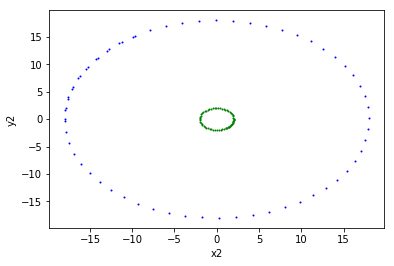

In [14]:
ax=df_x.plot.scatter(x='x1',y='y1',s=1,c='g')
ax=df_x.plot.scatter(x='x2',y='y2',s=1,c='b',ax=ax)


In [15]:
m=h5file['0/position'].attrs['mass']
num_part=h5file['0/position'].attrs['np'][0]
coords=['x','y','z']  

p_idx=np.arange(num_part)
d_idx=np.arange(3)
p_cols=[[ axis+str(a+1) for axis in coords] for a in p_idx]
t_list=df_x.index



In [102]:
X=np.array([100,1,15])

tr0_dict=dict()
tr1_dict=dict()
tr2_dict=dict()
tr3_dict=dict()

for t in t_list:
    row_tr0_dict=dict()
    row_tr1_dict=dict()
    row_tr2_dict=dict()
    row_tr3_dict=dict()
    for a in p_idx:
        ra=np.linalg.norm(X-df_x.loc[t][p_cols[a]])
        row_tr0_dict[('r',a)]=ra
        pa=df_p.loc[t][p_cols[a]]
        row_tr0_dict[('p2',a)]=pa.dot(pa)
        t_ret=t-ra
        row_tr0_dict[('t_ret',a)]=t_ret

        if t_ret >0:
            t_min=t_list[t_list<t_ret][-1]
            t_max=t_list[t_list>=t_ret][0]
            x_ret=np.array([lin_interpolation(t_min,t_ret,t_max,df_x.loc[t_min][p_cols[a][axis]],df_x.loc[t_max][p_cols[a][axis]]) for axis in d_idx])
            p_ret=np.array([lin_interpolation(t_min,t_ret,t_max,df_p.loc[t_min][p_cols[a][axis]],df_p.loc[t_max][p_cols[a][axis]]) for axis in d_idx])
            ra_ret=np.linalg.norm(X-x_ret)
            row_tr0_dict[('r_ret',a)]=ra_ret
            row_tr0_dict[('p2_ret',a)]=p_ret.dot(p_ret)
       
        nv=[]
        for axis in d_idx:
            xx=df_x.loc[t][p_cols[a][axis]]
            row_tr1_dict[('p',coords[axis],a)]=df_p.loc[t][p_cols[a][axis]]
            row_tr1_dict[('x',coords[axis],a)]=xx
            ra_i=X[axis]-xx 
            row_tr1_dict[('r',coords[axis],a)]=ra_i
            nv.append(ra_i/ra)
            row_tr1_dict[('n',coords[axis],a)]=nv[-1]
            
            if t_ret >0:
                      
                row_tr1_dict[('x_ret',a,coords[axis])]=x_ret[axis]
                row_tr1_dict[('p_ret',a,coords[axis])]=p_ret[axis]
                ra_ret_i=X[axis]-x_ret[axis] 
                row_tr1_dict[('r_ret',a,coords[axis])]=ra_ret_i      
                row_tr1_dict[('n_ret',a,coords[axis])]=ra_ret_i/ra_ret

        row_tr0_dict[('n.p',a)]=pa.dot(nv)
                
                
        for b in p_idx:
            if a == b:
                continue
            rab=np.linalg.norm(df_x.loc[t][p_cols[a]].values-df_x.loc[t][p_cols[b]].values)
            row_tr2_dict[('r',a,b)]=rab
                    
            rb=np.linalg.norm(X-df_x.loc[t][p_cols[b]])
            row_tr2_dict[('s',a,b)]=rab+ra+rb

            if t_ret >0:
                xb_ret=np.array([lin_interpolation(t_min,t_ret,t_max,df_x.loc[t_min][p_cols[b][axis]],df_x.loc[t_max][p_cols[b][axis]]) for axis in d_idx])
                rab_ret=np.linalg.norm(x_ret-xb_ret)
                row_tr2_dict[('r_ret',a,b)]=rab_ret
            
            for axis in d_idx:
                rab_i=df_x.loc[t][p_cols[a][axis]]-df_x.loc[t][p_cols[b][axis]]
                row_tr3_dict[('r',coords[axis],a,b)]=rab_i
                row_tr3_dict[('n',coords[axis],a,b)]=rab_i/rab if rab !=0 else np.nan
                
                if t_ret >0:
                    rab_ret_i=x_ret[axis]-xb_ret[axis]
                    row_tr3_dict[('r_ret',coords[axis],a,b)]=rab_ret_i
                    row_tr3_dict[('n_ret',coords[axis],a,b)]=rab_ret_i/rab_ret if rab_ret !=0 else np.nan
            
            
    tr0_dict[t]=row_tr0_dict
    tr1_dict[t]=row_tr1_dict
    tr2_dict[t]=row_tr2_dict
    tr3_dict[t]=row_tr3_dict
    
    
df_tr0=pd.DataFrame(tr0_dict).T
df_tr1=pd.DataFrame(tr1_dict).T
df_tr2=pd.DataFrame(tr2_dict).T
df_tr3=pd.DataFrame(tr3_dict).T


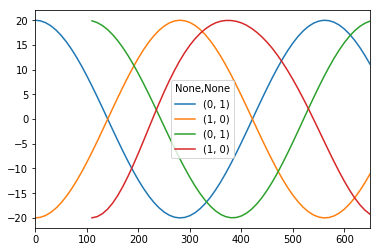

In [103]:
ax=df_tr3['r']['x'].plot()
df_tr3['r_ret']['x'].plot(ax=ax)

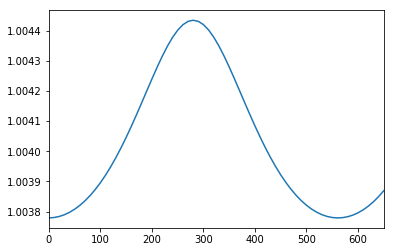

In [104]:
phi2= 4*(m[a]/df_tr0['r']).sum(axis=1)
phi4= 2*(df_tr0['p2']/(m[a]*df_tr0['r'])).sum(axis=1) 
psi=(1+0.125*(phi2+phi4))**4
psi.plot()

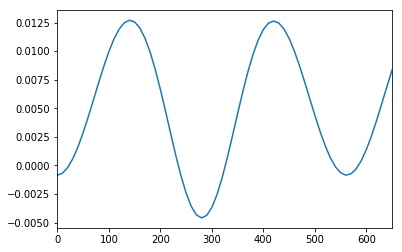

In [117]:
def hTT4(i,j):
    term1 =2*df_tr1['p',coords[i]]*df_tr1['p',coords[j]]
    term1+=(3*df_tr0['n.p']**2-5*df_tr0['p2'])*df_tr1['n',coords[i]]*df_tr1['n',coords[j]]
    term1+=12*df_tr0['n.p']*(df_tr1['n',coords[i]]*df_tr1['p',coords[j]]+df_tr1['n',coords[j]]*df_tr1['p',coords[i]])
    if i==j:
        term1+=(df_tr0['p2']-5*df_tr0['n.p']**2)/(m*df_tr0['r'])

    term2=0
    for a in p_idx:
        for b in p_idx:
            if a == b:
                continue
            term2 =-32*(1./df_tr2['r',a,b]+1./df_tr2['s',a,b])*df_tr3['n',coords[i],a,b]*df_tr3['n',coords[j],a,b]/df_tr2['s',a,b]
            term2+=2*( (df_tr0['r',a]+df_tr0['r',b])/df_tr2['r',a,b]**3+12./df_tr2['s',a,b]**2)*df_tr1['n',coords[i],a]*df_tr1['n',coords[j],b]
            term2+=32*(2./df_tr2['s',a,b]**2-1./df_tr2['r',a,b]**2)*(df_tr1['n',coords[i],a]*df_tr3['n',coords[j],a,b]+df_tr1['n',coords[j],a]*df_tr3['n',coords[i],a,b])
            term2+=(5./(df_tr2['r',a,b]*df_tr0['r',a])-(df_tr0['r',b]**2/df_tr0['r',a]+3*df_tr0['r',a])/df_tr2['r',a,b]**3-8*(1./df_tr0['r',a]+1./df_tr2['s',a,b])/df_tr2['s',a,b])*df_tr1['n',coords[i],a]*df_tr1['n',coords[j],a]
            if i==j:
                term2+=5*df_tr0['r',a]*(df_tr0['r',a]/df_tr0['r',b]-1)/df_tr2['r',a,b]**3-17./(df_tr2['r',a,b]*df_tr0['r',a])+4./(df_tr0['r',a]*df_tr0['r',b])+8*(1/df_tr0['r',a]+4./df_tr2['r',a,b])/df_tr2['s',a,b]
            term2*=m[a]*m[b]
    
    return 0.125*(term1/m).sum(axis=1)+0.125*term2

hTT4(0,0).plot()

In [109]:
df_tr1['n']

x                   y                   z          
               0         1         0         1         0         1
0.00    0.988438  0.991982  0.010086  0.008407  0.151291  0.126099
10.01   0.988416  0.991966  0.012337 -0.008501  0.151269  0.126218
20.01   0.988395  0.991640  0.014553 -0.025252  0.151208  0.126537
30.01   0.988376  0.991017  0.016708 -0.041732  0.151110  0.127057
40.01   0.988359  0.990116  0.018773 -0.057808  0.150976  0.127780
50.01   0.988346  0.988967  0.020720 -0.073346  0.150809  0.128706
60.01   0.988337  0.987604  0.022526 -0.088210  0.150610  0.129836
70.01   0.988333  0.986071  0.024166 -0.102261  0.150382  0.131171
80.01   0.988334  0.984419  0.025620 -0.115358  0.150129  0.132712
90.01   0.988343  0.982701  0.026872 -0.127357  0.149855  0.134458
100.01  0.988359  0.980978  0.027904 -0.138111  0.149562  0.136408
110.01  0.988382  0.979313  0.028706 -0.147469  0.149255  0.138560
120.01  0.988413  0.977770  0.029269 -0.155278  0.148938  0.140907
130.01  0.988452  0.976411  0.029587 -0.161385  0.148616  0.143442
140.01  0.988499  0.975297  0.029658 -0.165636  0.148291  0.146152
150.01  0.988553  0.974479  0.029482 -0.167878  0.147969  0.149020
160.01  0.988612  0.974000  0.029064 -0.167968  0.147653  0.152023
170.01  0.988677  0.973886  0.028409 -0.165772  0.147347  0.155131
180.01  0.988745  0.974147  0.027528 -0.161174  0.147054  0.158305
190.01  0.988816  0.974769  0.026433 -0.154087  0.146779  0.161498
200.01  0.988888  0.975715  0.025137 -0.144459  0.146524  0.164655
210.01  0.988959  0.976921  0.023658 -0.132288  0.146292  0.167708
220.01  0.989027  0.978296  0.022014 -0.117630  0.146086  0.170585
230.01  0.989092  0.979732  0.020225 -0.100616  0.145907  0.173208
240.01  0.989151  0.981105  0.018314 -0.081454  0.145758  0.175497
250.01  0.989203  0.982286  0.016302 -0.060439  0.145641  0.177374
260.01  0.989248  0.983159  0.014215 -0.037947  0.145556  0.178771
270.01  0.989284  0.983628  0.012076 -0.014426  0.145504  0.179635
280.01  0.989311  0.983632  0.009912  0.009624  0.145487  0.179930
290.01  0.989327  0.983155  0.007748  0.033673  0.145504  0.179645
...          ...       ...       ...       ...       ...       ...
360.01  0.989193  0.972654 -0.005332  0.163751  0.146520  0.164709
370.01  0.989148  0.971510 -0.006632  0.173403  0.146774  0.161555
380.01  0.989099  0.970739 -0.007732  0.180520  0.147049  0.158361
390.01  0.989048  0.970379 -0.008619  0.185154  0.147341  0.155186
400.01  0.988997  0.970441 -0.009278  0.187394  0.147647  0.152077
410.01  0.988945  0.970915 -0.009702  0.187353  0.147963  0.149071
420.01  0.988895  0.971771 -0.009883  0.185164  0.148285  0.146201
430.01  0.988847  0.972965 -0.009817  0.180970  0.148610  0.143488
440.01  0.988802  0.974441 -0.009505  0.174923  0.148933  0.140950
450.01  0.988759  0.976137 -0.008947  0.167175  0.149250  0.138599
460.01  0.988720  0.977986 -0.008149  0.157878  0.149557  0.136444
470.01  0.988683  0.979923 -0.007121  0.147184  0.149850  0.134491
480.01  0.988650  0.981881 -0.005875  0.135242  0.150125  0.132741
490.01  0.988619  0.983796 -0.004424  0.122199  0.150378  0.131196
500.01  0.988590  0.985612 -0.002787  0.108197  0.150606  0.129858
510.01  0.988563  0.987275 -0.000984  0.093376  0.150805  0.128724
520.01  0.988537  0.988739  0.000961  0.077875  0.150974  0.127795
530.01  0.988513  0.989965  0.003024  0.061829  0.151108  0.127068
540.01  0.988489  0.990923  0.005177  0.045371  0.151207  0.126544
550.01  0.988465  0.991589  0.007392  0.028633  0.151268  0.126222
560.01  0.988442  0.991948  0.009641  0.011748  0.151291  0.126100
570.01  0.988420  0.991994  0.011892 -0.005155  0.151276  0.126178
580.01  0.988399  0.991729  0.014117 -0.021944  0.151223  0.126458
590.01  0.988379  0.991164  0.016287 -0.038488  0.151132  0.126938
600.01  0.988362  0.990316  0.018371 -0.054655  0.151006  0.127621
610.01  0.988348  0.989213  0.020344 -0.070311  0.150845  0.128506
620.01  0.988338  0.987890  0.022180 -0.085319  0.150652  0.12

In [107]:
df_tr0['r']

,0,1
0.00,99.146356,118.953773
10.01,99.161228,118.842156
20.01,99.201087,118.542390
30.01,99.265410,118.056789
40.01,99.353346,117.389156
50.01,99.463736,116.544786
60.01,99.595130,115.530476
70.01,99.745807,114.354559
80.01,99.913804,113.026922
90.01,100.096942,111.559045


In [157]:
m=h5file['0/position'].attrs['mass']
num_part=h5file['0/position'].attrs['np'][0]
dim=h5file['0/position'].attrs['dim'][0]


def phi(xx,yy,zz,x,m,mR2,P2):
    X=np.array([xx,yy,zz])
    R1=X-x
    mR1=np.linalg.norm(R1,axis=1)
    phi2= 4*np.sum([m[a]/mR1[a] for a in p_idx ])
    phi4= 2*np.sum([P2[a]/(m[a]*mR1[a]) for a in p_idx])-2*np.sum([np.sum([0 if a==b else m[a]*m[b]/(mR1[a]*mR2[a,b]) for a in p_idx ]) for b in p_idx])

    return phi2+phi4


def HTT_ret(ra,ra_ret,uv,uv_ret,nv,nv_ret,i,j):
    un2=uv.dot(nv)**2
    un2_ret=uv_ret.dot(nv_ret)**2
    u2=uv.dot(uv)
    u2_ret=uv_ret.dot(uv_ret)
    result_t=0
    result_tret=0
    if(i==0):
        result_t+=u2-5*un2
        result_tret+=-2*u2_ret+2*un2_ret
    result_t+=2*uv[i]*uv[j]+nv[i]*nv[j]*(3*un2-5*u2)+12*uv.dot(nv)*(uv[i]*nv[j]+uv[j]*nv[i])
    result_tret+=4*uv_ret[i]*uv_ret[j]+nv_ret[i]*nv_ret[j]*(2*u2_ret+2*un2_ret)-8*uv_ret.dot(nv_ret)*(uv_ret[i]*nv_ret[j]+uv_ret[j]*nv_ret[i])
    return -0.25*result_t/ra+result_tret/ra_ret


def intHTT(tau,t,R1):
    return spi.simps((t-tau)/R1**3,x=tau)

def hTT(xx,yy,zz,x,p,m,mR2,n2,P2,i,j,df_x,df_p,t):
    dij=1 if i==j else 0
    X=np.array([xx,yy,zz])
    R1=X-x
    mR1=np.linalg.norm(R1,axis=1)
    n1=np.array([R1[a]/mR1[a] for a in p_idx])
    s1=0
    t_ret=t-mR1
    if np.all(t_ret>0):
        t_min=[df_x.index[df_x.index<t_ret[a]][-1] for a in p_idx]
        t_max=[df_x.index[df_x.index>=t_ret[a]][0] for a in p_idx]
        
        x_ret=np.array([ lin_interpolation(tm,t_ret[a],tM,df_x.loc[tm].values.reshape((3,num_part)).T[a],df_x.loc[tM].values.reshape((3,num_part)).T[a]) for tm,tM,a in zip(t_min,t_max,p_idx)])
        p_ret=np.array([ lin_interpolation(tm,t_ret[a],tM,df_p.loc[tm].values.reshape((3,num_part)).T[a],df_p.loc[tM].values.reshape((3,num_part)).T[a]) for tm,tM,a in zip(t_min,t_max,p_idx)])

        R1_ret=X-x_ret
        mR1_ret=np.linalg.norm(R1_ret,axis=1)
        n1_ret=np.array([R1_ret[a]/mR1_ret[a] for a in p_idx])

        R2_ret=np.array([[x_ret[b]-x_ret[a] for a in p_idx] for b in p_idx])
        mR2_ret=np.linalg.norm(R2_ret,axis=2)
        n2_ret=np.array([[ np.zeros_like(R2_ret[a,b]) if a==b else R2_ret[a,b]/mR2_ret[a,b] for a in p_idx] for b in p_idx])

        tau=[df_x.index[ (df_x.index>=t_ret[a]) *(df_x.index <= t)] for a in p_idx]
        x_tau=[[df_x.loc[tt].values.reshape((3,num_part)).T[a] for tt in tau[a] ] for a in p_idx]
        R1_tau=[[ X-x_tau[a][tt] for tt in np.arange(len(tau[a])) ] for a in p_idx]
        mR1_tau=[[ np.linalg.norm(R1_tau[a][tt]) for tt in np.arange(len(tau[a])) ] for a in p_idx]
        
    hret=0
    for a in p_idx:
        s1+=dij*(P2[a]-5*n1[a].dot(p[a]))+2*p[a,i]*p[a,j] + n1[a,i]*n1[a,j]*(3*(n1[a].dot(p[a]))**2 -5*P2[a])+12*(n1[a].dot(p[a])*(n1[a,i]*p[a,j]+n1[a,j]*p[a,i]))
        s1/=4*(m[a]*mR1[a])
        
        if np.all(t_ret>0):
            hret+=HTT_ret(mR1[a],mR1_ret[a],p[a]/np.sqrt(m[a]),p_ret[a]/np.sqrt(m[a]),n1[a],n1_ret[a],i,j)
            print(intHTT(tau[a],t,np.array(mR1_tau[a])))
            
        s2=0
        for b in p_idx:
            if a==b:
                continue
            s_ab=mR1[a]+mR1[b]+mR2[a,b]
            s2+= -32*n2[a,b,i]*n2[a,b,j]*(1.0/mR2[a,b]+1.0/s_ab)/s_ab+2*n1[a,i]*n1[a,j]*((mR1[a]+mR1[b])/mR2[a,b]**3+12/s_ab**2)
            s2+= 32*(n1[a,i]*n2[a,b,j]+n1[a,j]*n2[a,b,i])*(2.0/s_ab**2-1.0/mR2[a,b]**2) + n1[a,i]*n1[a,j]*(5.0/(mR2[a,b]*mR1[a])-(mR1[b]**2/mR1[a]+3*mR1[a])/mR2[a,b]**3 - 8*(1.0/mR1[a]+1.0/s_ab)/s_ab)
            s2+= dij*(5*mR1[a]*(mR1[a]/mR1[b]-1)/mR2[a,b]**3 - 17.0/(mR2[a,b]*mR1[a]) + 4.0/(mR1[a]*mR1[b]) + 8*(1.0/mR1[a]+4.0/mR2[a,b])/s_ab )
            s2*=m[a]*m[b]*0.125

            if np.all(t_ret>0):
                hret-=HTT_ret(mR1[a],mR1_ret[a],np.sqrt(0.5*m[a]*m[b]/mR2[a,b])*n2[a,b],np.sqrt(0.5*m[a]*m[b]/mR2_ret[a,b])*n2_ret[a,b],n1[a],n1_ret[a],i,j)

    return s1+s2+hret

nx=64
ny=64
nz=4

L=[200,200,1]
C=[0,0,0]

xx=np.linspace(start=C[0]-L[0]/2.,stop=C[0]+L[0]/2.,num=nx)
yy=np.linspace(start=C[1]-L[1]/2.,stop=C[1]+L[1]/2.,num=ny)
zz=np.linspace(start=C[2]-L[2]/2.,stop=C[2]+L[2]/2.,num=nz)
X,Y,Z =np.meshgrid(xx,yy,zz)


t_list=df_x.index


In [158]:
xc=100
yc=0
zc=0

dump_list=list()
for t in t_list:
    x=df_x.loc[t].values.reshape((3,num_part)).T
    p=df_p.loc[t].values.reshape((3,num_part)).T
        
    P2=np.array([p[a].dot(p[a]) for a in p_idx])
    
    R2=np.array([[x[b]-x[a] for a in p_idx] for b in p_idx])
    mR2=np.linalg.norm(R2,axis=2)
    
    n2=np.array([[ np.zeros_like(R2[a,b]) if a==b else R2[a,b]/mR2[a,b] for a in p_idx] for b in p_idx])
    
    Phi=phi(xc,yc,zc,x,m,mR2,P2)
    Htt_11=hTT(xc,yc,zc,x,p,m,mR2,n2,P2,0,0,df_x,df_p,t)
    
    Psi4=(1+0.125*Phi)**4
    dump_list.append({"psi4":Psi4,"t":t,'hTT_00':Htt_11})


0.00425667995712
0.00323119534937
0.00424030080609
0.00330829162724
0.00422154742918
0.00340302738808
0.00520222609888
0.00351634021616
0.00517591799204
0.0030269077195
0.00514754815483
0.00316255337312
0.00511752188381
0.00331662440275
0.00508625788804
0.00349001098452
0.00505418093294
0.00368342958521
0.0050207213446
0.00389634590773


In [159]:
df_wave=pd.DataFrame(dump_list)

In [96]:
1./8

0.125

In [22]:
dump_list=list()
for t in t_list:
    x=df_x.loc[t].values.reshape((3,num_part)).T
    p=df_p.loc[t].values.reshape((3,num_part)).T
        
    P2=np.array([p[a].dot(p[a]) for a in p_idx])
    
    R2=np.array([[x[b]-x[a] for a in p_idx] for b in p_idx])
    mR2=np.linalg.norm(R2,axis=2)
    n2=np.array([[ np.zeros_like(R2[a,b]) if a==b else R2[a,b]/mR2[a,b] for a in p_idx] for b in p_idx])
    
    Phi=list()
    Htt_11=list()
    for xc,yc,zc in zip(X.flatten(),Y.flatten(),Z.flatten()):
        Phi.append(phi(xc,yc,zc,x,m,mR2,P2))
        Htt_11.append(hTT(xc,yc,zc,x,p,m,mR2,n2,P2,0,0,df_x,df_p,t))
    df_phi=pd.DataFrame({'x':X.flatten(),'y':Y.flatten(),'z':Z.flatten(),'phi':Phi,'hTT_00':Htt_11})

    z_val=df_phi['z'].abs().max()
    df_z=df_phi.query('z=='+str(z_val))
    Psi4=(1+0.125*df_z['phi'].values.reshape(nx,ny))**4
    dump_list.append({"psi4":Psi4,"t":t,'hTT_00':df_z['hTT_00'].values.reshape(nx,ny)})

KeyboardInterrupt: 

In [8]:
def plot_dump(t):
#    fig = plt.figure(figsize=(10,5))
#    ax = fig.add_subplot(111, projection='3d')
#    ax.plot_wireframe(X[:,:,0], Y[:,:,0], np.log(dumps_list[t]['z']), rstride=1, cstride=1)
    plt.imshow(dump_list[t]['hTT_00'], extent=(np.min(xx), np.max(xx), np.min(yy), np.max(yy)),
        cmap=cm.hot)
    plt.show()
d=interact(plot_dump,t=widgets.IntSlider(min=0,max=len(dump_list)-1,continuous_update=True))

In [6]:
grid_size=h5file['coordinates/x'].shape
xc=h5file['coordinates/x'][:,:,grid_size[2]/2]
yc=h5file['coordinates/y'][:,:,grid_size[2]/2]

r_indx=np.sqrt(xc**2+yc**2) < 25

dumps_len=len(h5file['0/fields'].keys())
metric=[h5file['0/fields/'+str(i)+'/metric_0_0'][:,:,grid_size[2]/2] for i in np.arange(dumps_len)]

def plot_metric_map(i):
    data=metric[i]
    data[r_indx]=1
    plt.imshow(data, extent=(np.amin(xc), np.amax(xc), np.amin(yc), np.amax(yc)),
            cmap=cm.hot, norm=LogNorm())
    plt.colorbar()
    plt.show()
    

In [37]:
d=interact(plot_metric_map,i=widgets.IntSlider(max=dumps_len-1))

In [15]:
def get_waves(h5file):
    l_modes=[2,3] 
    columns=["t"]
    name=["Q","O","CQ"]
    for l in l_modes:
        for p in ['R','I']:
            for m in np.arange(start=-l,stop=l+1):
                columns.append(p+'['+name[l-2]+'m='+str(m)+"]")
    l=3
    for p in ['R','I']:
        for m in np.arange(start=-l,stop=l+1):
            columns.append(p+'['+name[l-1]+'m='+str(m)+"]")
    return pd.DataFrame(h5file['0']['waves'][:],columns=columns)       
    
df_waves2=get_waves(h5file).set_index('t')

In [49]:
help(df_x[p_cols[0]].apply)

Help on method apply in module pandas.core.frame:

apply(self, func, axis=0, broadcast=False, raw=False, reduce=None, args=(), **kwds) method of pandas.core.frame.DataFrame instance
    Applies function along input axis of DataFrame.
    
    Objects passed to functions are Series objects having index
    either the DataFrame's index (axis=0) or the columns (axis=1).
    Return type depends on whether passed function aggregates, or the
    reduce argument if the DataFrame is empty.
    
    Parameters
    ----------
    func : function
        Function to apply to each column/row
    axis : {0 or 'index', 1 or 'columns'}, default 0
        * 0 or 'index': apply function to each column
        * 1 or 'columns': apply function to each row
    broadcast : boolean, default False
        For aggregation functions, return object of same size with values
        propagated
    raw : boolean, default False
        If False, convert each row or column into a Series. If raw=True the
        pass

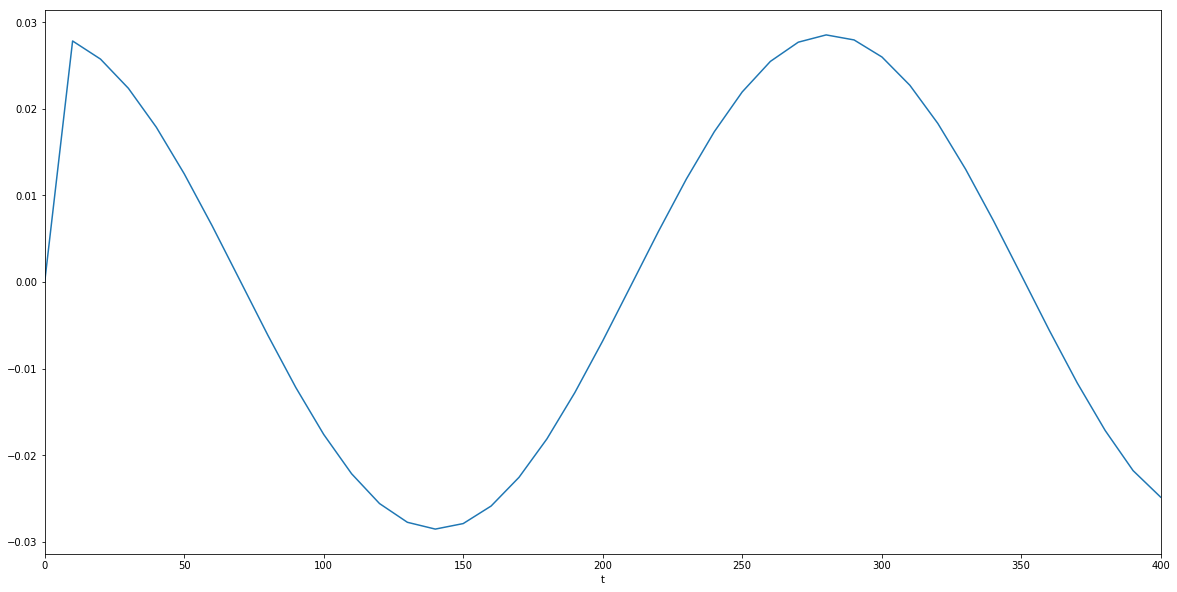

In [17]:
df_waves2['R[Qm=2]'].plot(figsize=(20,10))

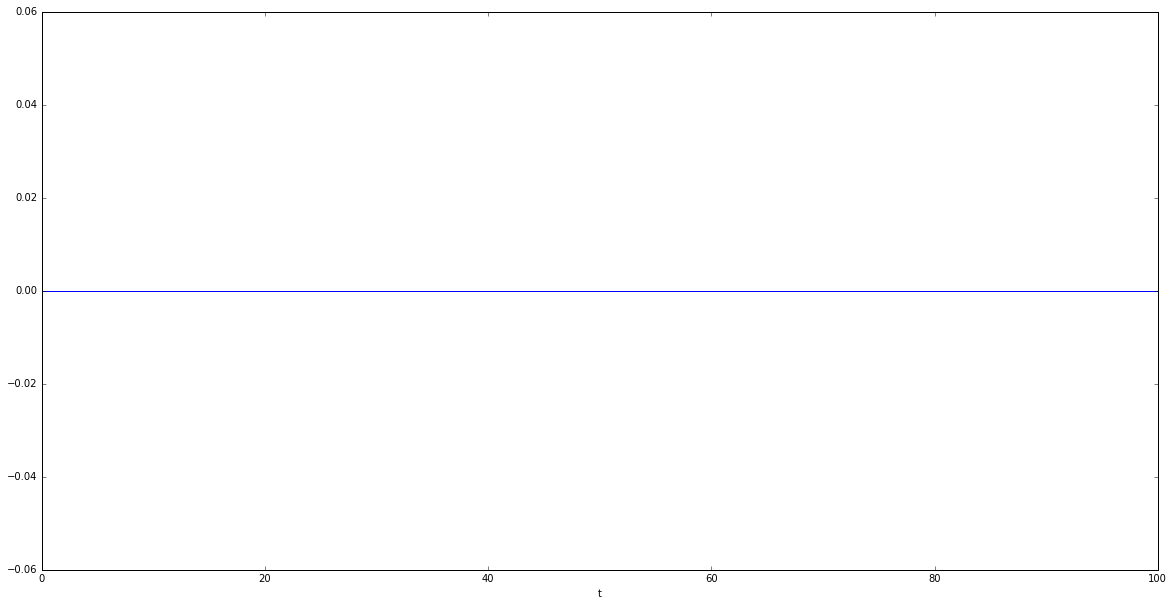

In [24]:
df_waves['R[Qm=-1]'].plot(figsize=(20,10))

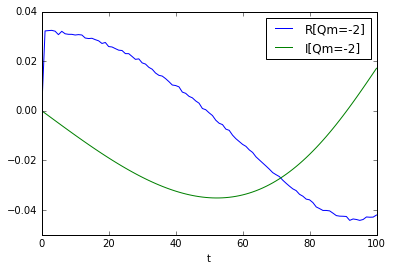

In [25]:
df_waves.iloc[:,(0,5)].plot()

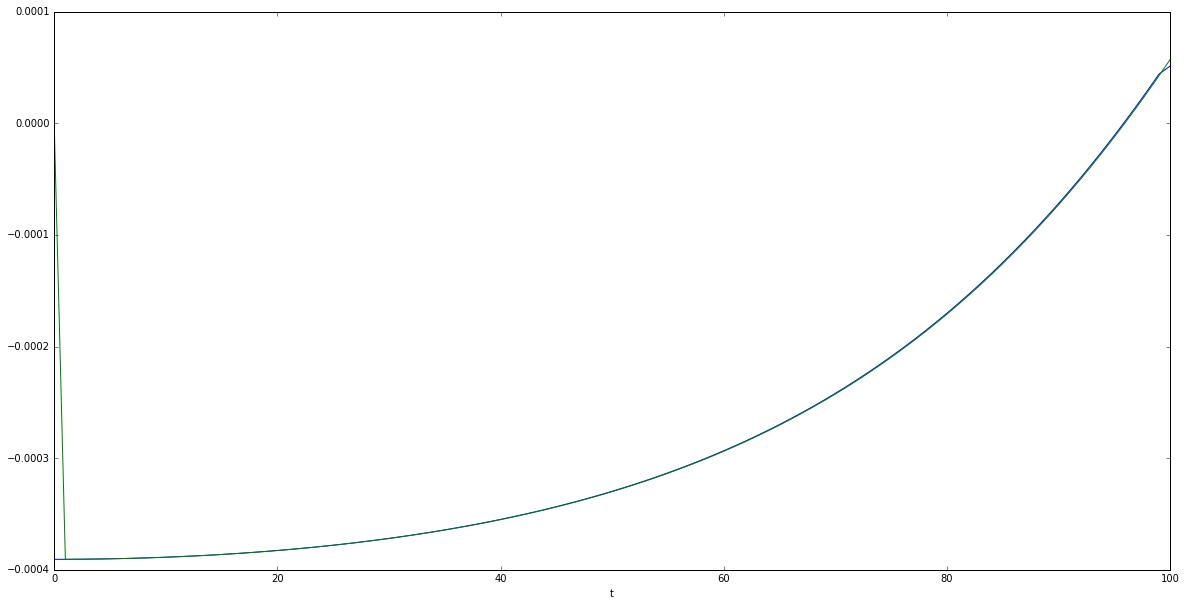

In [26]:
ax=pd.Series(np.gradient(df_dxdt['x1'].values,df_dxdt.index.values),index=df_dxdt.index).plot(figsize=(20,10))
(df_ddxdt2['x1']).plot(figsize=(20,10),ax=ax)


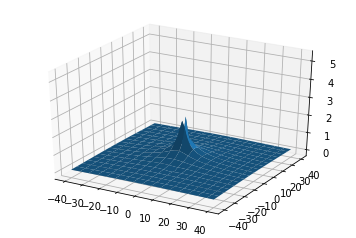

In [8]:
grid_size=h5file['coordinates/x'].shape
xc=h5file['coordinates/x'][:,:,grid_size[2]/2]
yc=h5file['coordinates/y'][:,:,grid_size[2]/2]
metric=h5file['0/fields/40/metric_0_0'][:,:,grid_size[2]/2]

fig_2d= plt.figure(1)
ax=fig_2d.add_subplot(1, 1, 1, projection='3d')
ax.plot_surface(xc, yc, np.log10(metric), rstride=4, cstride=4, linewidth=0)

In [56]:
df_p

,x1,x2,y1,y2,z1,z2
t,,,,,,
0.0,0.000000,0.000000,-0.020125,0.020125,0,0
10.0,-0.002245,0.002245,-0.019999,0.019999,0,0
20.0,-0.004463,0.004463,-0.019624,0.019624,0,0
30.0,-0.006624,0.006624,-0.019003,0.019003,0,0
40.0,-0.008703,0.008703,-0.018145,0.018145,0,0
50.0,-0.010673,0.010673,-0.017061,0.017061,0,0
60.0,-0.012510,0.012510,-0.015764,0.015764,0,0
70.0,-0.014191,0.014191,-0.014270,0.014270,0,0
80.0,-0.015694,0.015694,-0.012597,0.012597,0,0


In [55]:
df_x

,x1,x2,y1,y2,z1,z2
t,,,,,,
0.0,2.000000,-18.000000,0.000000,0.000000,0,0
10.0,1.987513,-17.887617,-0.223141,2.008271,0,0
20.0,1.950208,-17.551872,-0.443496,3.991465,0,0
30.0,1.888551,-16.996957,-0.658313,5.924817,0,0
40.0,1.803311,-16.229801,-0.864910,7.784186,0,0
50.0,1.695554,-15.259983,-1.060706,9.546355,0,0
60.0,1.566624,-14.099615,-1.243258,11.189318,0,0
70.0,1.418132,-12.763185,-1.410284,12.692560,0,0
80.0,1.251931,-11.267381,-1.559701,14.037310,0,0


In [49]:
df_x.iloc[10].values.reshape((3,2)).T[0]

array([ 0.87490237, -1.79848409,  0.        ])

In [46]:
df_x.iloc[10]

x1     0.874902
x2    -7.874121
y1    -1.798484
y2    16.186357
z1     0.000000
z2     0.000000
Name: 100.0, dtype: float64

In [1]:
a<-seq.int(from = 2,to = 2000)

SyntaxError: invalid syntax (<ipython-input-1-8b469654521e>, line 1)